In [1]:
from __future__ import absolute_import, division, print_function

import pathlib

import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


# Data 

### Download data 

In [3]:
dataset_path = keras.utils.get_file("auto-mpg", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 6us/step


'C:\\Users\\fqdg1\\.keras\\datasets\\auto-mpg'

### Create DF with the data 

In [4]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 
               'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values = "?", comment='\t',
                         sep=" ", skipinitialspace=True)

data = raw_dataset.copy()
data.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data 

In [5]:
data.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
data = data.dropna()
data.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Create vector for new features

In [7]:
origin = data.pop('Origin')
origin

0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    2
395    1
396    1
397    1
Name: Origin, Length: 392, dtype: int64

Add new features

In [8]:
data['USA'] = (origin == 1) * 1.
data['Europe'] = (origin == 2) * 1.
data['Japan'] = (origin == 3) * 1.
data.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### Split features
X - train dataset  
Y - test dataset  

In [9]:
X = data.sample(frac=0.8, random_state=0)
Y = data.drop(X.index)

### Plots
Get plots of pairs of the distributions

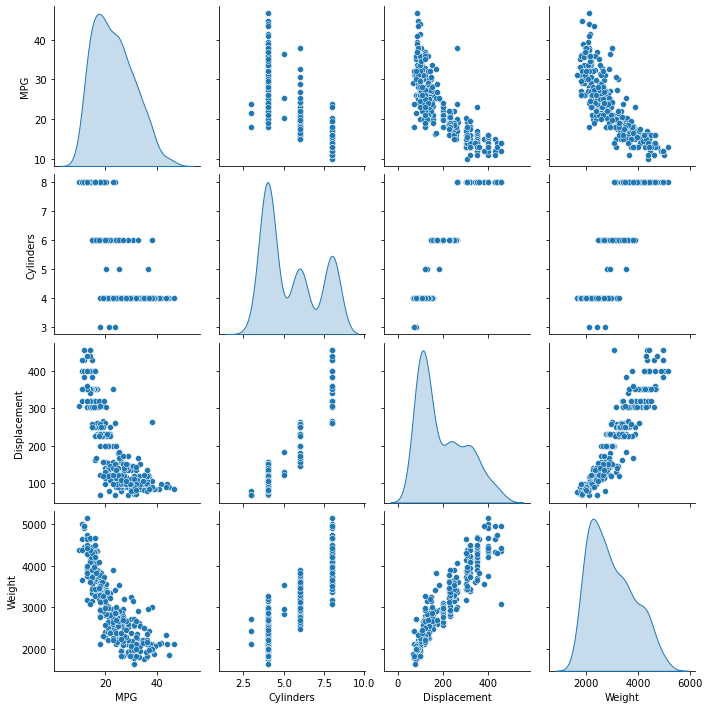

In [10]:
sns.pairplot(X[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Get some statistics desctibe

In [11]:
x_stats = X.describe()
x_stats.pop("MPG")
x_stats = x_stats.transpose()
x_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


ranges of the values is very diffrent. It's bad for train a ML model. Let's fix that.

In [12]:
x_labels = X.pop("MPG")
y_labels = Y.pop("MPG")

### Normalize the data 
<center> $ x_{norm} = {(x - x^{train}_{\mu}) \over x^{train}_{\sigma} } $ <center>

In [13]:
def norm(x, stats=x_stats):
    return (x - stats['mean']) / stats['std']

x_norm = norm(X)
y_norm = norm(Y)

In [14]:
x_norm

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
...,...,...,...,...,...,...,...,...,...
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,0.774676,-0.465148,-0.495225
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,0.774676,-0.465148,-0.495225
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-1.286751,-0.465148,2.012852
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-1.286751,-0.465148,2.012852


# Model 

In [13]:
def build_model(X):
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(X.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse'])
    
    return model

In [14]:
model = build_model(X)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [16]:
example_batch = x_norm[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.31831735],
       [-0.00369142],
       [-0.02220377],
       [-0.02934438],
       [-0.29138094],
       [ 0.06474423],
       [-0.26459637],
       [ 0.37167352],
       [ 0.1642781 ],
       [ 0.01985059]], dtype=float32)

In [17]:
# Progress-bar
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print("")
        print('.', end='')
        
EPOCHS = 1000

history = model.fit(x_norm, x_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose = 0, 
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.286531,1.001411,2.286531,8.952886,2.332886,8.952886,995
996,2.401263,1.039031,2.401263,9.038071,2.366458,9.038071,996
997,2.433296,1.042089,2.433296,8.816533,2.356013,8.816533,997
998,2.381310,1.003405,2.381310,9.086042,2.356531,9.086042,998
999,2.230589,0.979073,2.230589,8.673314,2.331539,8.673314,999


## View values of cost function (mae)

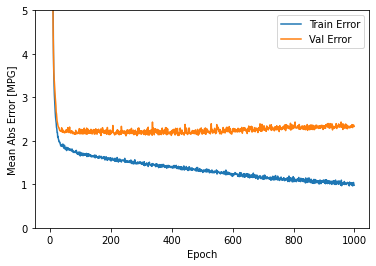

In [19]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.legend()
    plt.ylim([0, 5])
    
plot_history(history)


..................................................

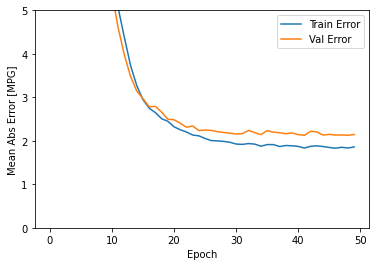

In [20]:
model = build_model(X)

# Prevent overfitting with early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_norm, x_labels, epochs=EPOCHS,
                   validation_split = 0.2, verbose = 0, callbacks = [early_stop, PrintDot()])

plot_history(history)

In [21]:
loss, mae, mse = model.evaluate(x_norm, x_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.87 MPG


## Predictions 

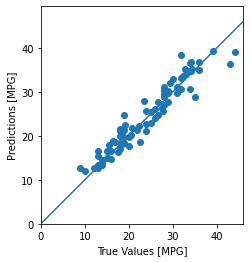

In [22]:
y_hat = model.predict(y_norm).flatten()

plt.scatter(y_labels, y_hat)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

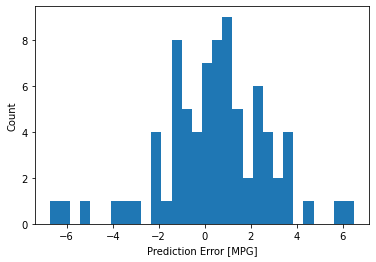

In [48]:
error = y_hat - y_labels
plt.hist(error, bins = 30)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Number of samples is very small. That is why the histogram is not quite gaussian.